## Reading data

In [1]:
with open('imdb_reviews.pcl2', 'rb') as f:
    import pickle
    data = pickle.load(f)

In [2]:
data.head()

,id,sentiment,review,score
0,5814,1,"[stuff, going, moment, mj, started, listening,...",8
1,2381,1,"[classic, war, timothy, hines, entertaining, f...",9
2,7759,0,"[film, starts, manager, nicholas, bell, giving...",3
3,3630,0,"[must, assumed, praised, film, greatest, filme...",4
4,9495,1,"[superbly, trashy, wondrously, unpretentious, ...",8


## Co-occurence matrix

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

countVectorizer = CountVectorizer(ngram_range=(1,1))
reviews = [' '.join(r) for r in data['review']]
# review -> [word_count]
rw_vecs = countVectorizer.fit_transform(reviews)
words = countVectorizer.get_feature_names()

In [4]:
# co-occurence matrix
coo = rw_vecs.T * rw_vecs

In [5]:
import numpy as np
word_to_index = dict(zip(words, range(len(words))))
top_words = sorted([p for p in zip(words, np.asarray(rw_vecs.sum(axis = 0)).ravel()) if len(p[0]) > 3],
                   key=lambda x: x[1],
                   reverse=True)[:20]
top_indices = list(map(lambda p: word_to_index[p[0]], top_words))
top_vects = coo[top_indices]
top_vects.shape

(20, 70138)

## SVD

In [6]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD()
svd.fit(coo)

TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=None, tol=0.0)

In [7]:
svd_points = svd.transform(top_vects)
svd_points[:,1]

array([-98701.989463  , -85836.47636025, -35181.56232001, -24561.43934391,
       -22342.54496668, -20161.90798762, -18380.33080337, -21761.78413498,
       -16746.15440084, -15448.92343376, -13906.30826156, -14585.23222444,
       -14720.25187894, -15364.61306833, -14235.37734478, -14299.78090777,
       -13830.94568346, -13347.0662795 , -14682.69828613, -13081.42966706])

In [8]:
def plot_words(words, points):
    import matplotlib
    import matplotlib.pyplot as plt
    import matplotlib.cm as cmx
    import matplotlib.colors as colors
    
    scalar_map = cmx.ScalarMappable(norm=colors.Normalize(vmin=0, vmax=len(words)))
    t = np.linspace(0, 1, len(points))
    col = np.cos(t)
    
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_autoscale_on(True)
    ax.autoscale_view(True, True, True)
    hndls = list()
    for i, p in enumerate(points):
        h = ax.scatter(p[0], p[1], 
                       color=scalar_map.to_rgba(i), 
                       label=words[i],
                       marker='x')
        ax.annotate(words[i], p, color=scalar_map.to_rgba(i))
        hndls.append(h)
    ax.legend(handles=hndls)
    matplotlib.rcParams.update({'font.size': 14})
    plt.show()

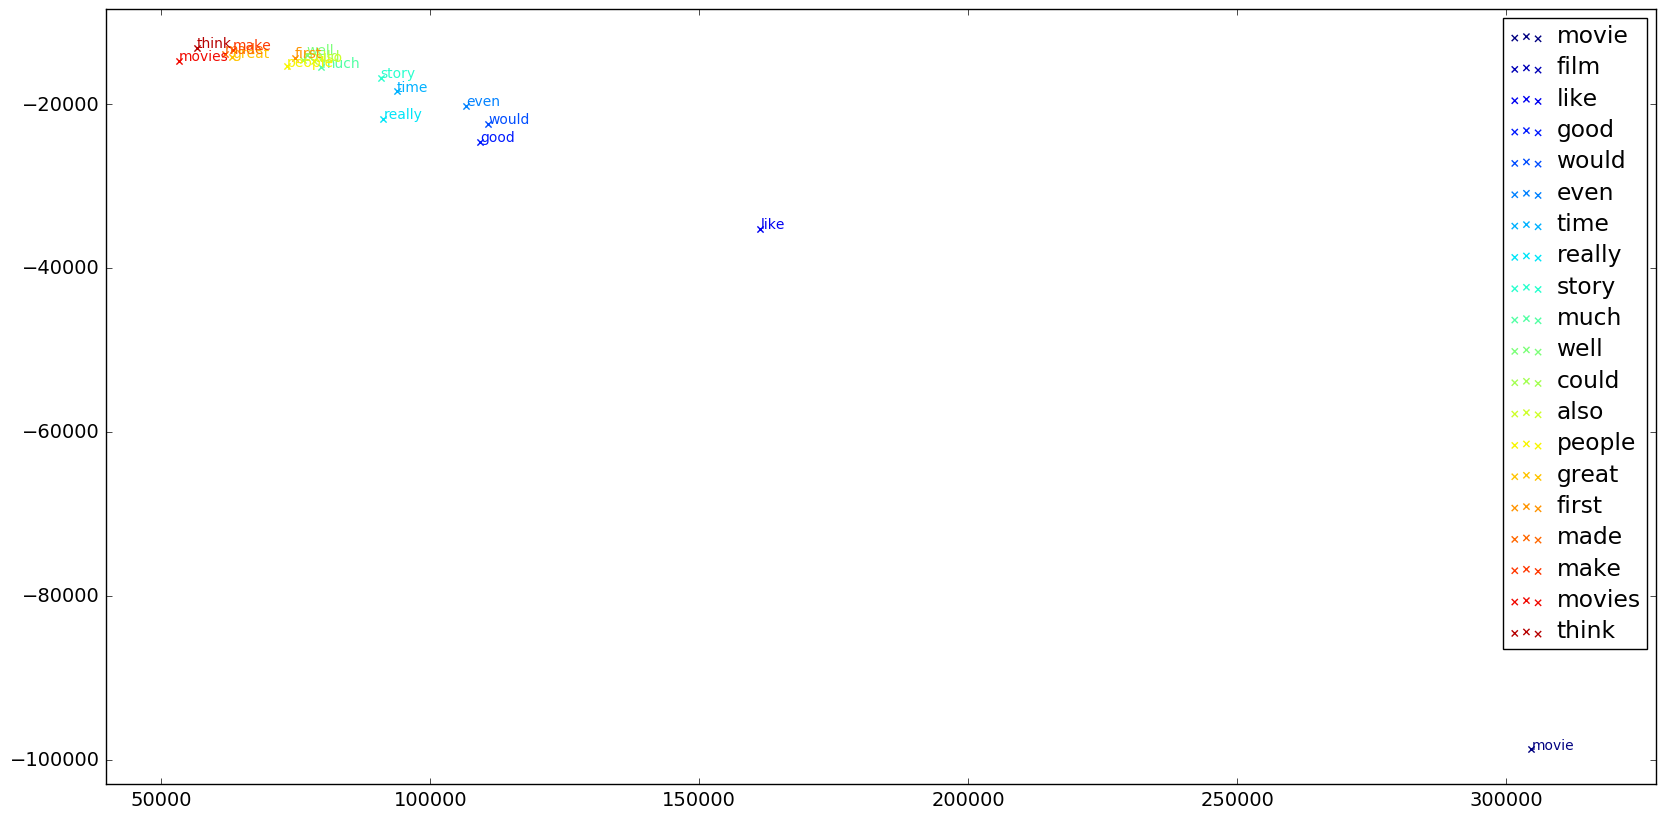

In [9]:
plot_words([w[0] for w in top_words], svd_points)

## Word 2 Vec

In [10]:
import word2vec

In [112]:
def get_model():
    fi = 'reviews.txt'
    fo = 'vecs.bin'
    with open(fi, 'w') as f:
        for r in data.review:
            for w in r:
                f.write("{} ".format(w))
            f.write("\n")
    
    word2vec.word2vec(fi, fo)
    model = word2vec.load(fo)
    return model

v2w_model = get_model()

In [113]:
v2w_top_vecs = np.array([v2w_model.vectors[model.vocab_hash[w]] for w in [w[0] for w in top_words]])

In [13]:
from sklearn.manifold import TSNE
tsne_model = TSNE()
tsne_words = tsne_model.fit_transform(v2w_top_vecs)

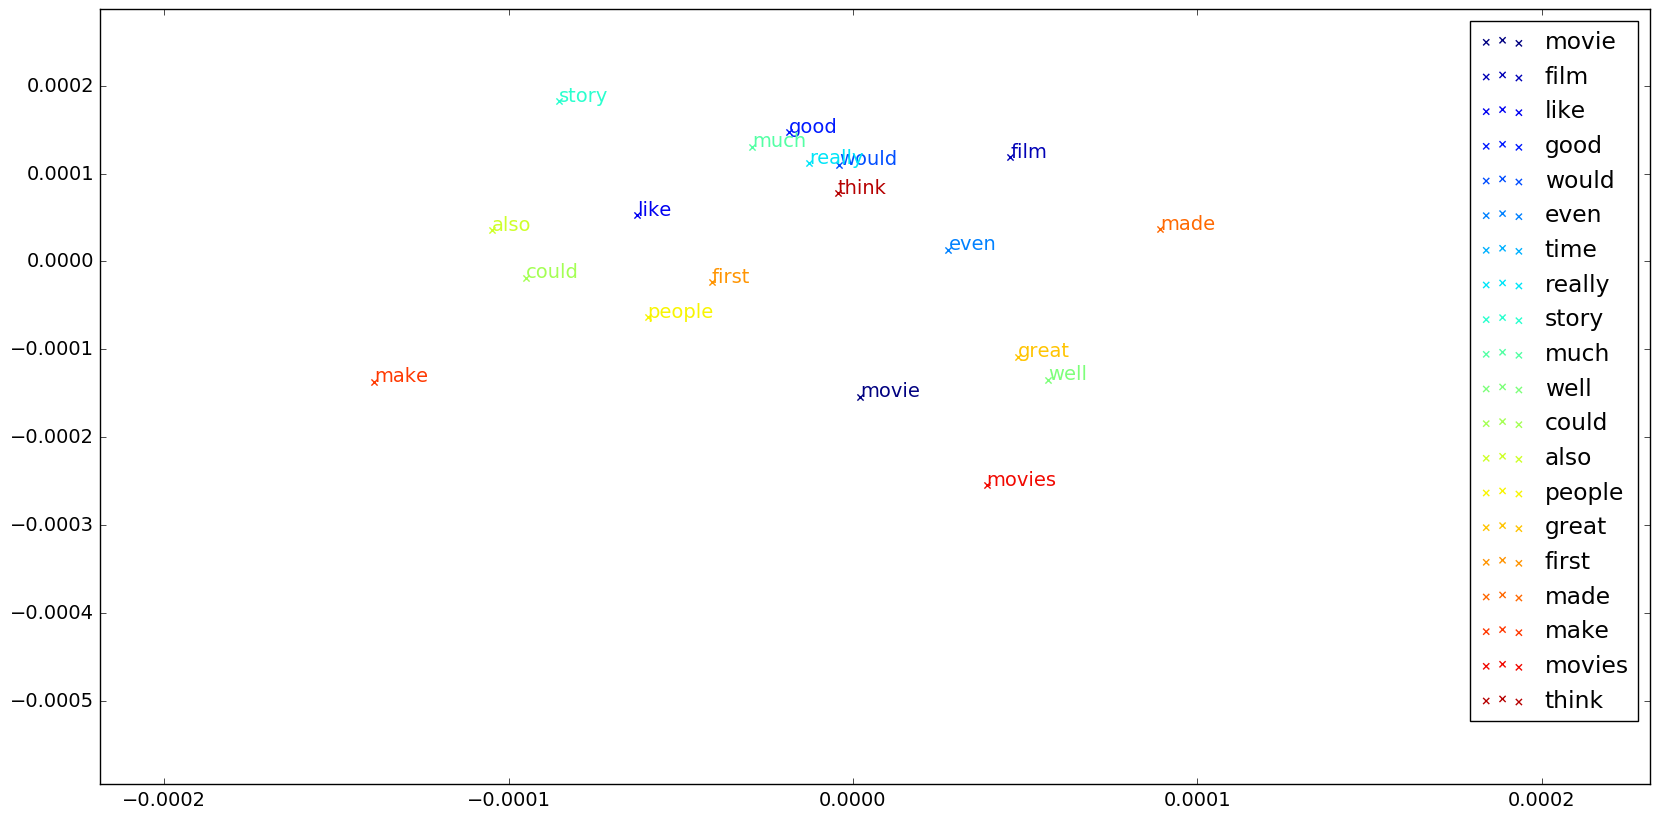

In [14]:
plot_words([w[0] for w in top_words], tsne_words)

## Splitting dataset

In [15]:
import pandas as pd

def shuffle(df, n=1, axis=0):     
    df = df.copy()
    for _ in range(n):
         df.apply(np.random.shuffle, axis=axis)
    return df

def print_proportions(df, label):
    print(label)
    print("    sent 1   :  {}".format(len(df.loc[df['sentiment'] == 1]) / len(df)))
    print("    sent 2   :  {}".format(len(df.loc[df['sentiment'] == 0]) / len(df)))
    for s in range(1, 11):
        print("    score {} : {}".format(s, len(df.loc[df['score'] == s]) / len(df)))
    
def split_data():
    bds = lambda sz: [int(np.ceil(sz * 0.8)), int(np.ceil(sz * 0.9))]
    scores = range(1, 11)
    sentiments = range(0, 2)
    train = pd.DataFrame()
    test = pd.DataFrame()
    validate = pd.DataFrame()
    for y in sentiments:
        sent_data = data.loc[data['sentiment'] == y]
        for score in scores:
            df = sent_data.loc[sent_data['score'] == score]
            tr, te, va = np.split(df, bds(len(df)))
            train = train.append(tr)
            test = test.append(te)
            validate = validate.append(va)
    train = train.reset_index(drop=True).sample(n=len(train)).reset_index(drop=True)
    test = test.reset_index(drop=True).sample(n=len(test)).reset_index(drop=True)
    validate = validate.reset_index(drop=True).sample(n=len(validate)).reset_index(drop=True)
    
    return (train, test, validate)

In [16]:
(train, test, valid) = split_data()

In [17]:
print_proportions(data, "Input data")
print_proportions(train, "Train")
print_proportions(test, "Test")
print_proportions(valid, "Validate")

Input data
    sent 1   :  0.5
    sent 2   :  0.5
    score 1 : 0.204
    score 2 : 0.09136
    score 3 : 0.0968
    score 4 : 0.10784
    score 5 : 0.0
    score 6 : 0.0
    score 7 : 0.09984
    score 8 : 0.12036
    score 9 : 0.09052
    score 10 : 0.18928
Train
    sent 1   :  0.5000249962505624
    sent 2   :  0.4999750037494376
    score 1 : 0.2039694045893116
    score 2 : 0.09138629205619157
    score 3 : 0.09678548217767335
    score 4 : 0.10783382492626106
    score 5 : 0.0
    score 6 : 0.0
    score 7 : 0.09983502474628805
    score 8 : 0.12038194270859372
    score 9 : 0.09053641953706944
    score 10 : 0.1892716092586112
Test
    sent 1   :  0.5
    sent 2   :  0.5
    score 1 : 0.204
    score 2 : 0.0912
    score 3 : 0.0968
    score 4 : 0.108
    score 5 : 0.0
    score 6 : 0.0
    score 7 : 0.1
    score 8 : 0.1204
    score 9 : 0.0904
    score 10 : 0.1892
Validate
    sent 1   :  0.49979975971165397
    sent 2   :  0.500200240288346
    score 1 : 0.2042450941129355

## Basic sentiment analysis

In [75]:
from scipy.sparse import csr_matrix
sent_vec = csr_matrix([2 * train['sentiment'] - 1])

In [76]:
counter = CountVectorizer(ngram_range=(1,1))
reviews = [' '.join(r) for r in train['review']]
# review -> [word_count]
train_rw_vecs = countVectorizer.fit_transform(reviews)
train_words = countVectorizer.get_feature_names()
train_word_idx = dict(zip(train_words, range(len(train_words))))
print(train_rw_vecs.shape)



def get_word_sentiment(w):
    idx = train_word_idx[w]
    res = 0
    for s, c in train_rw_vecs[idx].data:
        res += (1 if c > 0 else 0) * (2 * s - 1)
    return res

(20003, 64226)


In [105]:
sums = sent_vec * train_rw_vecs
sums = np.asarray(sums.todense()).ravel()
word_sentiments = dict([(train_words[i], np.sign(sums[i])) for i in range(len(sums))])

In [110]:
def classify(r):
    score = 0
    for w in r:
        if w in word_sentiments:
            score += word_sentiments[w] 
    return np.sign(score)

def classify_and_check():
    ok = 0
    for s, r in zip(test['sentiment'], test['review']):
        s = 2 * s - 1
        ok += 1 if classify(r) == s else 0
    return ok / len(test)

In [111]:
classify_and_check()

0.7912

## Mean vecs